In [1]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


In [2]:
def pendulum_rhs(t, y, gamma, L=1):
    """ 
    Simple pendulum with damping 
    y = [theta, omega], 
    alpha = - (g/L) * sin(theta) - gamma*omega
    """
    g = 9.81
    theta, omega = y
    alpha = - (g / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]


def generate_data_at_max_resolution(num_time_points, params_df, IC_df, noise_perc=10, random_seed=111, L=5.0):
    """
    Simulates the pendulum ODE for multiple initial conditions (and optionally parameters)
    but here simplified to a single param set for illustration. 
    Returns:
        data_matrix_df_list_full (list of DataFrames): Each DF has the columns [t, x, y].
        t_eval_full (numpy array): The time points used (length = num_time_points).
    """
    L = 5.0

    # Time span
    t_span = (0.0, 10)  # from 0 to 10 seconds
    #Valuation points
    t_eval_ = np.linspace(t_span[0], t_span[1], num_time_points)
    data_matrix_df_list = []


    for param_index in params_df.index:
        params = params_df.loc[param_index]
        # Define parameters
        m_c = params['m_c']  # Mass of the cart (kg)
        m_p = params['m_p']  # Mass of the pendulum (kg)
        l = params['l']    # Length of the pendulum (m)
        for IC_index in IC_df.index:
            IC = IC_df.loc[IC_index]
            y0 = IC.values
                    # Parameters
            theta0 = IC["theta"]  # Initial angle (radians)
            omega0 = IC["omega"]        # Initial angular velocity (radians per second)
            gamma = 0.0         # Damping coefficient
            # Solve the ODEs
            # sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
            sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], t_eval=t_eval_, rtol=1e-8)
            
            sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
            sol_df["x"] = L*np.sin(sol_df["theta"])
            sol_df["y"] = -L*np.cos(sol_df["theta"])
            sol_df["t"] = t_eval_
            data_matrix_df_list.append(sol_df[["t", "x", "y"]])


    # data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
    # data_matrix_features = data_matrix_df_list[0].columns
    for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["t"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
        noisy_data_df["t"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

    return data_matrix_df_list, t_eval_

# ---------------------------------------------------------
# 2. Downsample to 'mid' points
# ---------------------------------------------------------
def downsample_data(data_matrix_df_list_full, new_num_time_points):
    """
    Given the full data (each DF has 2000 points),
    downsample to new_num_time_points points using uniform spacing.
    """
    data_matrix_df_list_downsampled = []
    for df_full in data_matrix_df_list_full:
        n_full = len(df_full)
        # Indices for downsampling
        indices = np.round(np.linspace(0, n_full - 1, new_num_time_points)).astype(int)
        df_down = df_full.iloc[indices].reset_index(drop=True)
        data_matrix_df_list_downsampled.append(df_down)
    return data_matrix_df_list_downsampled


In [3]:
"""
----------------------------------------------------------------------------------------------------------------
### Synthesizing data from different ICs

----------------------------------------------------------------------------------------------------------------
"""

IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond_simp_pend.csv"))
# IC_df = IC_df.iloc[[0,3]]
params_df = pd.read_csv(os.path.join(path_to_add, "parameters/pend_param.csv"))
g = 9.81   # Acceleration due to gravity (m/s^2)
# First, generate your full, noise-added dataset at 2000 points
max_points = 100
wrong_relation_dict = {}
poly_degree = 2

noise_perc = 0

wrong_relation_dict[noise_perc] = []

data_matrix_df_list_full, t_eval_full = generate_data_at_max_resolution(
    max_points, 
    params_df,
    IC_df,
    noise_perc=noise_perc, 
    random_seed=1
)

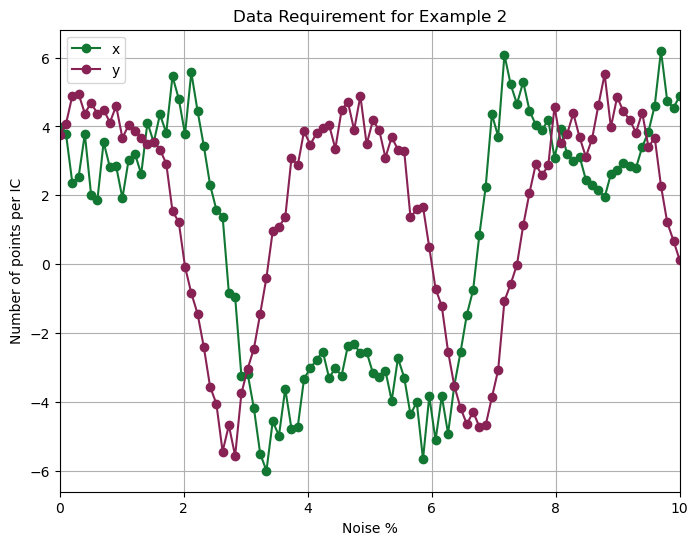

In [4]:
from matplotlib import pyplot as plt

time_exact = data_matrix_df_list_full[0]["t"]
df_ = add_noise_to_df(data_matrix_df_list_full[0], 15)

# plt.plot(df_["t"], df_["x"])
# plt.plot(df_["t"], df_["y"])
plt.figure(figsize=(8, 6))



color_dict = {"x":"#117733",
              "y": "#882255"}
            #   "30dB":"#117733",
            #    "20dB":"#882255"}
cases = ["x", "y"]
# markers = ['o']
# markers = ['^', 'o']

for case in cases:
    # Extracting keys and corresponding mean and standard deviation
    y_means = df_[case]

    # Plotting
    plt.plot(time_exact, y_means,'-o',color=color_dict[case], label=case)

# Set x-axis ticks
# plt.xticks([1, 5, 10, 15])
plt.xlim(0, 10)
# Labels and title
plt.xlabel("Noise %")
plt.ylabel("Number of points per IC")
plt.title("Data Requirement for Example 2")
plt.legend()
plt.grid(True)

plt.savefig("noisy_pendulum.svg")